What this code does
1. Runs all TSM code for the Sun
1. Adds noise to the data
1. Bins it
1. Then finds an equation for the background
1. Then finds the gaussian on that background
1. Locates V_max

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as c
from scipy.signal import find_peaks
from scipy.signal import peak_prominences
from scipy.signal import peak_widths
from scipy.optimize import curve_fit
import math
from statistics import stdev 

## Bin_it
This function bins one array and reduces another array to match its length so they can be plotted together. This is done to reduce the noise whihc comes from the noise on the data.
###  Inputs
- yvalues: y array, the Power normally called Fulldata in this code
- xvalues: x array, the frequency
- binsize: the size of the bin the y values will be averaged in, every binsizeth value will also be taken from the x array<br>
### Outputs
- Binned y array (Power)
- reduced x array (Frequency)

In [2]:
def bin_it(yvalues,xvalues,binsize):
    '''puts an array into averaged bins of a given size'''
    N=int(math.ceil(len(yvalues)/binsize))
    C=0
    newy=[]
    while C<N:
        if (C+1)*binsize<len(yvalues):
            Q=(np.sum(yvalues[C*binsize:(C+1)*binsize]))/binsize
        else:
            Q=(np.sum(yvalues[C*binsize:len(yvalues)]))/binsize
        newy.append(Q)
        C+=1
    y=np.array(newy)
    x=xvalues[0::binsize] 
    return y[0:len(y)-1],x[0:len(y)-1]

## addnoise
adds noise to and array. The method used to generate the noise was taken from a recommended scientific paper
### Input
- pure: orignal array
### output
- array with noise added

In [3]:
#Adds random noise
def addnoise(pure):
    vary = np.random.uniform(0, 1, pure.shape)
    signal = -(pure* np.log(vary))
    return signal

## gausgran
Is the equation of a gaussian where the base is not just a flat line, it is adjusted by an array fitted to the background called fittedgran.
### Inputs
- x: array over which the gaussian with background should be plotted
- height: Height of the gaussian
- centre: Centre of the gaussian
- width: Width of the gaussain at half its height
### Output
- An equation with gives a gaussian on a line fitted to the background of the data

In [4]:
def gausgran(x,height,centre,width):
    '''plots a gaussian acounting for granulation'''
    return height*np.exp((-(x-centre)**2)/(2*width**2))+fittedgran

In [5]:
def gaus(x,height,centre,width):
    '''plots a gaussian acounting for granulation'''
    return height*np.exp((-(x-centre)**2)/(2*width**2))

## findgran
Finds an equation which describes the background noise of the initial data and returns the values needed to plot the background
### Inputs
- x: x value array (frequency) 
- y: y value arrat (power)
### Output
- best_vals is an array of to integers which can be put into graneq to fit the background noise

In [6]:
def findgran(x,y):
    #guess_vals=[np.max(y),y[round(len(y)/4)]]
    guess_vals=[0, 0]
    best_vals, covar =curve_fit(graneq, x, y,p0=guess_vals)
    return best_vals

## graneq
plots returns the y values of the background if the x array and two constants are inserted
### Inputs
- x: x array (frequency)
- A: constant calulated by findgran
- tau: constant calulated by findgran
### Output
- array of y values of the background

In [7]:
def graneq(x,A,tau,SN):
    '''equation to describe the background'''
    return A/(1+(2*np.pi*x*tau)**2)+SN

In [8]:
def find_nearest(array, value):
    '''finds value closest to a given value in an array'''
    array = np.asarray(array)
    idx = (np.abs(array-value)).argmin()
    return idx

In [9]:
data = np.genfromtxt('Kypoints.txt', delimiter=' ')
extradata = np.genfromtxt('Kotherstuff.txt', delimiter=' ')

In [14]:
def vmaxplot(powerdata,truevmax,truevmag,N,binsize,Starnumber):
    frequency=data[0]
    C=0
    fails=0
    amps=[]
    centres=[]
    widths=[]
    while C<N:
        y,x=bin_it(addnoise(powerdata),frequency,binsize)
        SN = 18*10**(-0.4*(11.0-truevmag))
        bv,covar =curve_fit(graneq,x,y,p0=[0,0,SN],bounds=([0,0,SN-SN/100],[np.inf,np.inf,SN+SN/100]))
        background=graneq(x,bv[0],bv[1],bv[2])
        fittedgran=background
        yflat=y-fittedgran
        p0=[0.05,6000,350]
        try:
            best_vals, covar = curve_fit(gaus,x,yflat,p0=p0,bounds=([0.0,3000,300],[np.inf,14000,np.inf]))
            amps.append(best_vals[0])
            centres.append(best_vals[1])
            widths.append(best_vals[2])
            C+=1
        except:
            fails+=1
            C+=1
    if len(centres)>0:
        average_v_max=np.mean(centres)
        difference=np.abs(average_v_max-truevmax)
        print(f'{fails}/{N} trails failed')
        print(f'average v_max {average_v_max} which is {difference} away from the true value of {truevmax}')
        fig, axs  = plt.subplots(3, 2,figsize=(12,12))
        fig.suptitle(f'Star {int(Starnumber)}',fontsize=20)
        axs[0,0].plot(frequency,powerdata,label='data')
        axs[0,0].set_title('Data provided by TSM team')
        axs[0,0].set_xlabel('Frequency')
        axs[0,0].set_ylabel('Power')
        axs[0,0].legend()
        axs[0,1].plot(frequency,addnoise(powerdata),label='data')
        axs[0,1].set_title(f'Noise added')
        axs[0,1].set_xlabel('Frequency')
        axs[0,1].set_ylabel('Power')
        axs[0,1].legend()
        axs[1,0].plot(x,y,label='data')
        axs[1,0].plot(x,background,label='Fitted background')
        axs[1,0].axvline(truevmax,color='yellow', label='True vmax')
        axs[1,0].set_title('Binned binsize: {binsize} background fitted')
        axs[1,0].set_xlabel('Frequency')
        axs[1,0].set_ylabel('Power')
        axs[1,0].legend()
        axs[1,1].plot(x,yflat,label='data')
        axs[1,1].axhline(0,color='black')
        axs[1,1].set_title('Background subtracted from data')
        axs[1,1].set_xlabel('Frequency')
        axs[1,1].set_ylabel('Power')
        axs[1,1].legend()
        axs[2,0].plot(x,yflat,label='data')
        axs[2,0].plot(x,gaus(x,np.mean(amps),np.mean(centres),np.mean(widths)),label='Fitted gaussian')
        axs[2,0].axvline(truevmax,color='yellow', label='True vmax')
        axs[2,0].axvline(average_v_max,color='purple', label='Fitted vmax')
        axs[2,0].set_title('Fitted gaussian')
        axs[2,0].set_xlabel('Frequency')
        axs[2,0].set_ylabel('Power')
        axs[2,0].legend()
        bottom=find_nearest(x,truevmax-2500)
        top=find_nearest(x,truevmax+2500)
        xf=x[bottom:top]
        yflatf=yflat[bottom:top]
        axs[2,1].plot(xf,yflatf,label='data')
        axs[2,1].plot(xf,gaus(xf,np.mean(amps),np.mean(centres),np.mean(widths)),label='Fitted gaussian')
        axs[2,1].axvline(truevmax,color='yellow', label='True vmax')
        axs[2,1].axvline(average_v_max,color='purple', label='Fitted vmax')
        axs[2,1].set_title('Cropped fitted gaussian')
        axs[2,1].set_xlabel('Frequency')
        axs[2,1].set_ylabel('Power')
        axs[2,1].legend()
        plt.subplots_adjust(top=0.95, hspace=0.3)
        plt.show()
    else:
        print('fails')
        plt.plot(x,y,label='data')
        plt.plot(x,background,label='background')
        plt.legend()
        plt.show()

0/100 trails failed
average v_max 4878.899144925791 which is 35.365567633181854 away from the true value of 4843.533577292609


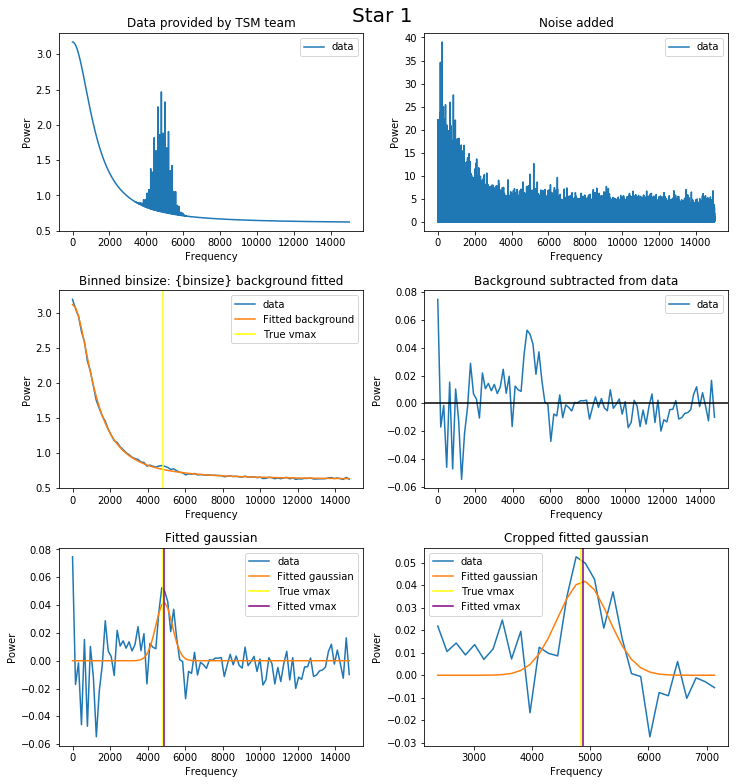

0/100 trails failed
average v_max 6099.92930503379 which is 121.15286068766545 away from the true value of 5978.776444346125


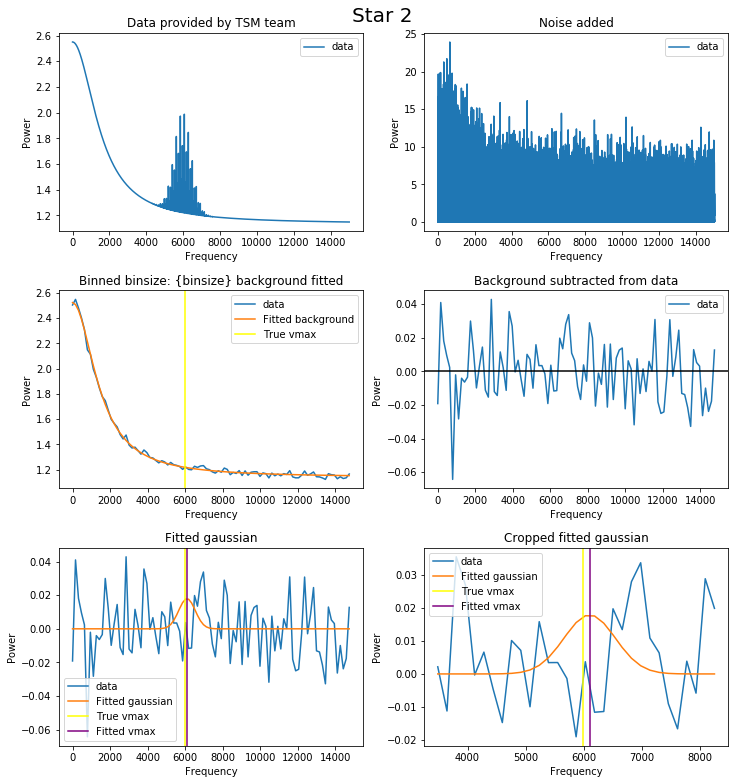

0/100 trails failed
average v_max 6045.044417612671 which is 51.199212128080035 away from the true value of 6096.243629740751


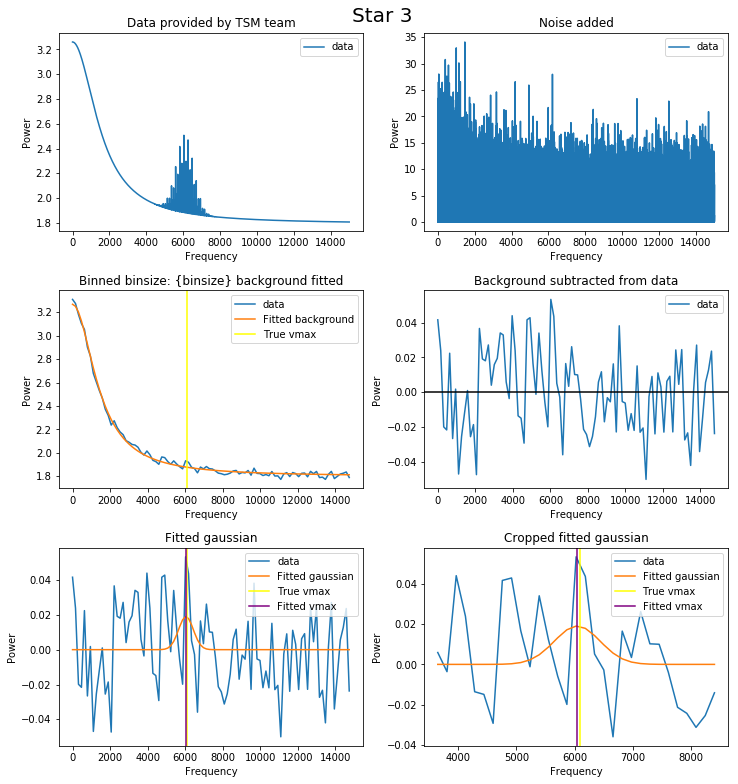

0/100 trails failed
average v_max 4967.98797300055 which is 108.2560297129312 away from the true value of 4859.731943287618


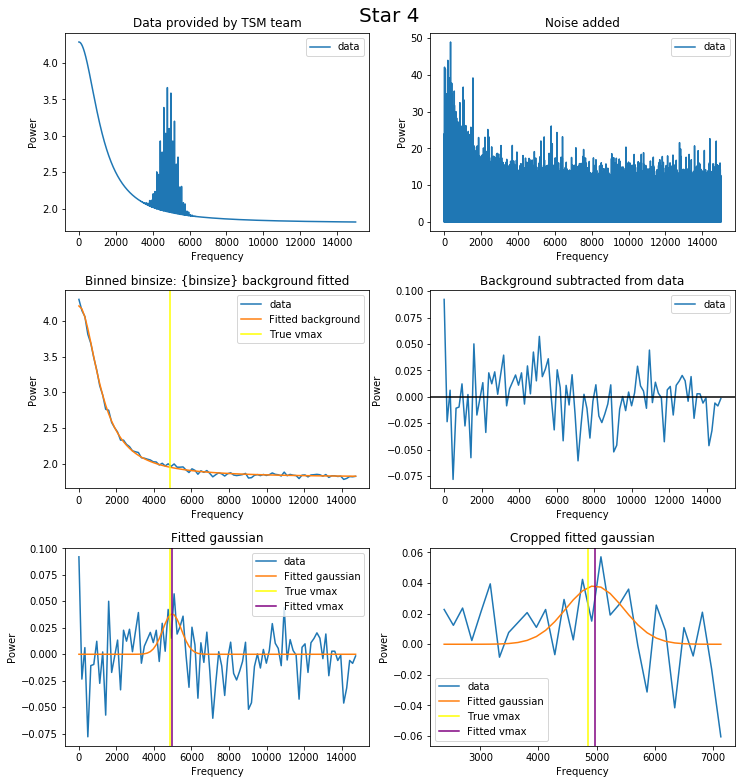

0/100 trails failed
average v_max 5724.5453975755845 which is 102.91466462511289 away from the true value of 5621.630732950472


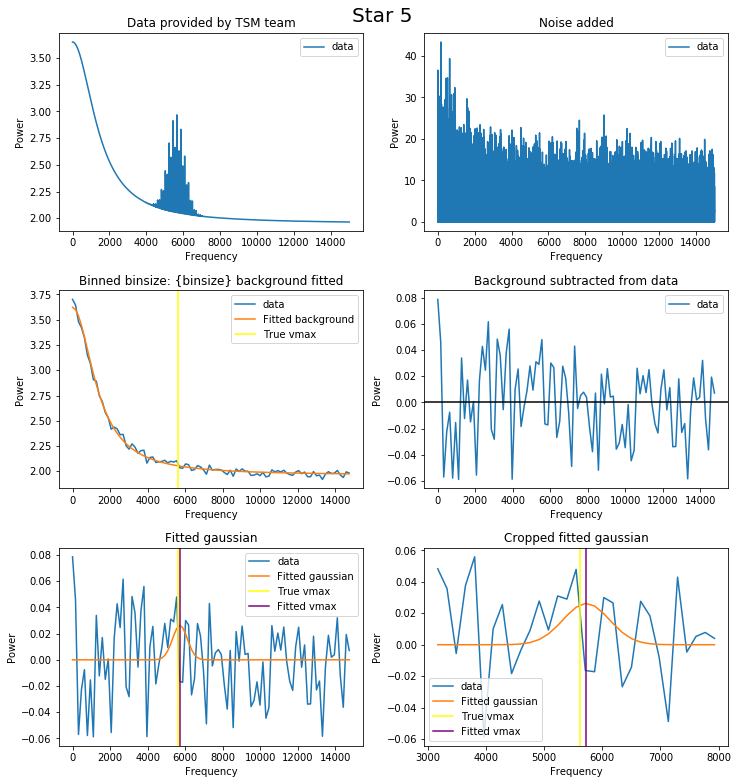

0/100 trails failed
average v_max 5777.663883311121 which is 101.40342888892064 away from the true value of 5676.2604544222


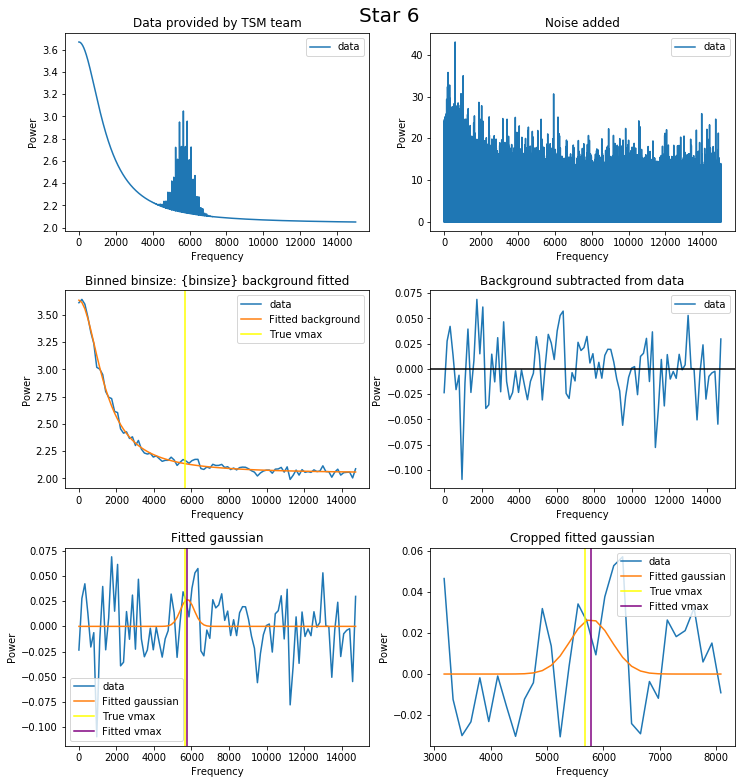

0/100 trails failed
average v_max 5805.414382862009 which is 307.3184313105148 away from the true value of 5498.095951551494


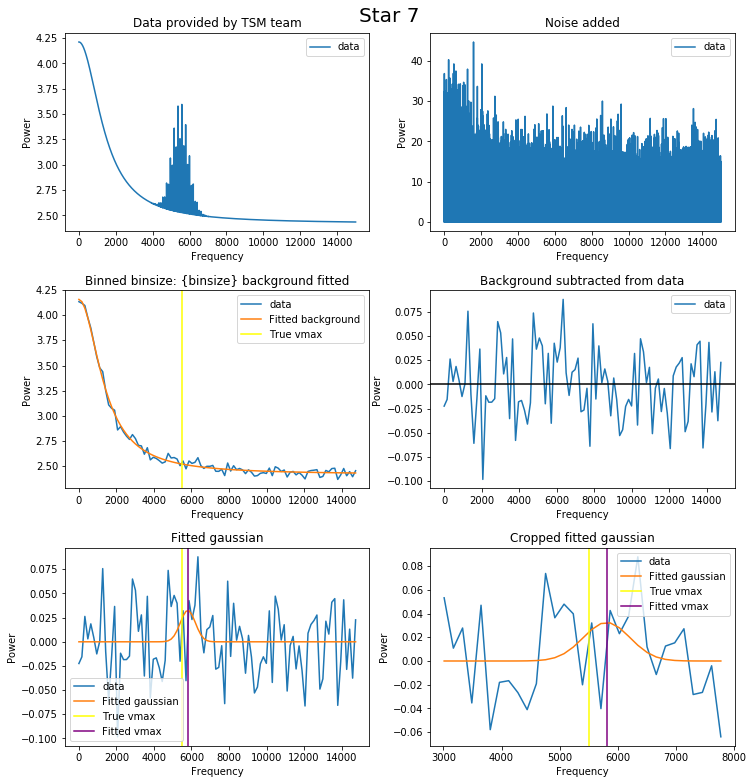

0/100 trails failed
average v_max 5287.04351397645 which is 520.9526827935679 away from the true value of 4766.0908311828825


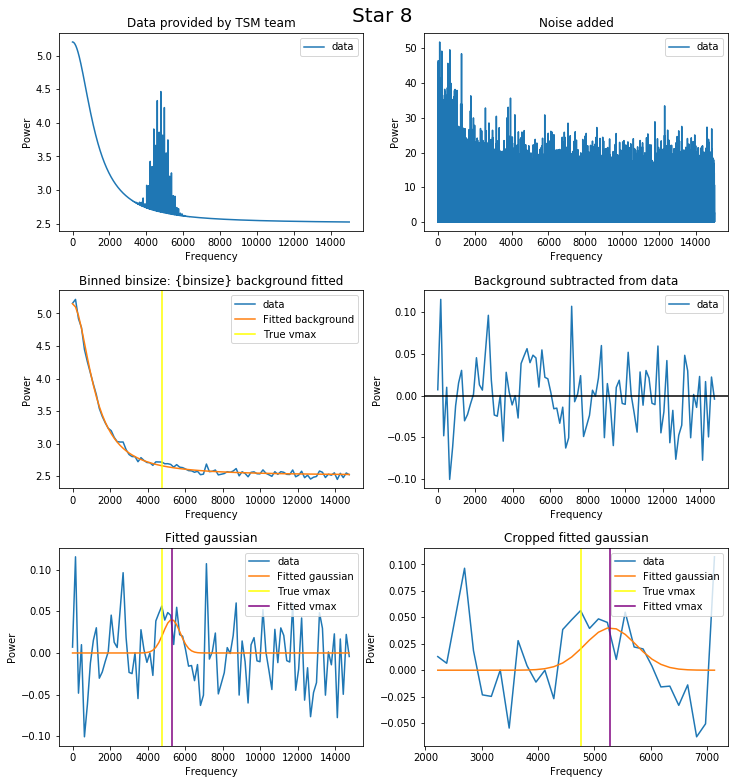

0/100 trails failed
average v_max 6022.763353633194 which is 149.05586528738786 away from the true value of 5873.707488345806


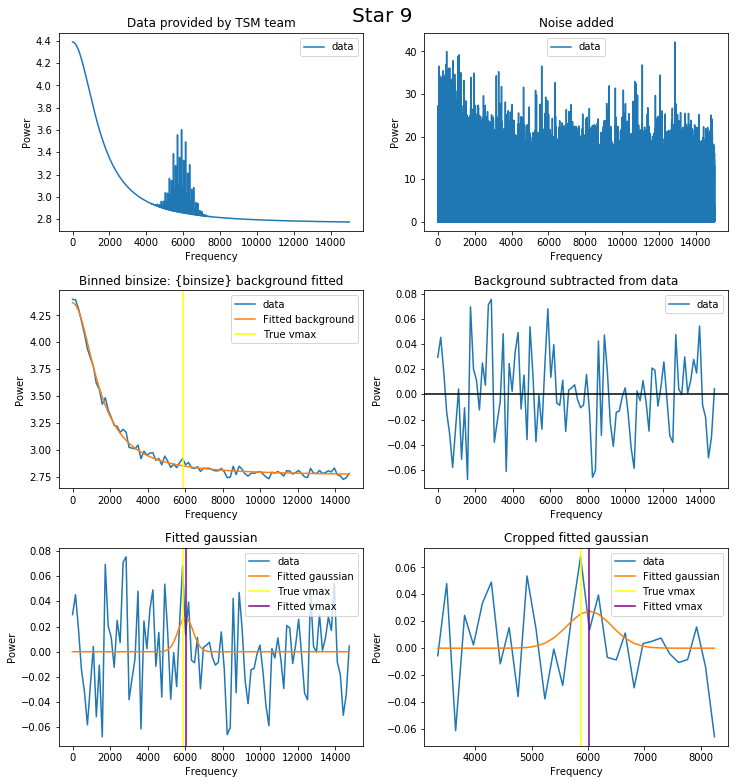

0/100 trails failed
average v_max 6093.417163381789 which is 128.39152327688498 away from the true value of 5965.025640104904


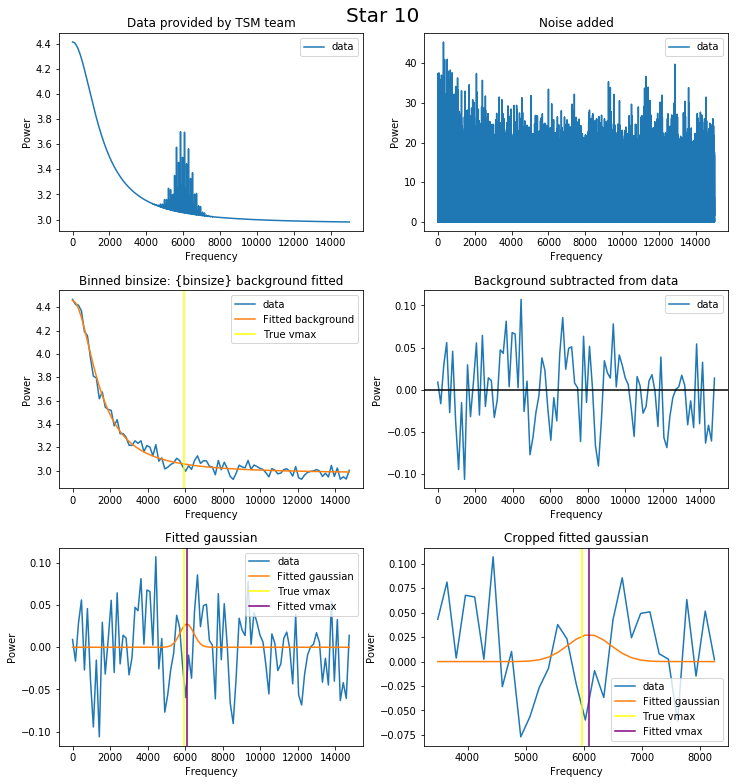

In [15]:
m=np.linspace(1,10,10)
binsize=6000
number_of_trails=100
for n in m:
    vmaxplot(data[int(n)],extradata[int(n)-1,1],extradata[int(n)-1,2],number_of_trails,binsize,n)